## Mitsuba quickstart

- Import Mitsuba in Python and set the “variant”

- Load a scene from disk

- Render a scene

- Write a rendered image to disk

In [1]:
# import mitsuba 
import mitsuba as mi
import drjit as dr


In [2]:
# set variant
mi.set_variant("scalar_rgb")

In [20]:
# load scene
scene = mi.load_file("../scenes/cbox.xml")

In [21]:
# render scene
image = mi.render(scene, spp=256)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


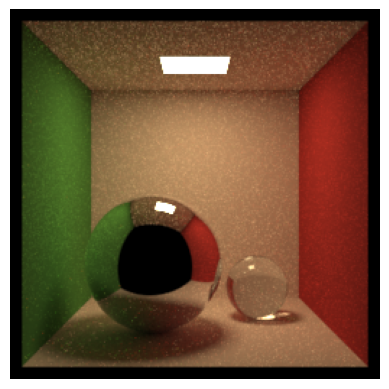

In [22]:
import matplotlib.pyplot as plt

plt.axis("off")
plt.imshow(image ** (1.0 / 2.2)); # approximate sRGB tonemapping

In [23]:
# Write image to disk
mi.util.write_bitmap("my_first_render.png", image)
mi.util.write_bitmap("my_first_render.exr", image)

# Editing a scene

- List exposed parameters of Mitsuba objects

- Edit a scene and update its internal state accordingly

In [7]:
mi.set_variant('llvm_ad_rgb')

scene = mi.load_file("../scenes/simple.xml")

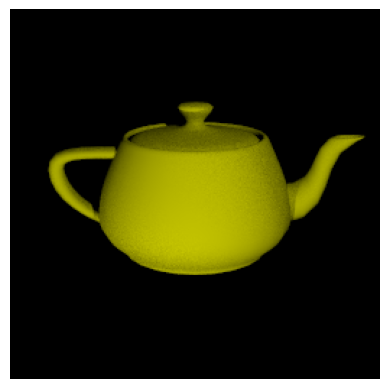

In [8]:
original_image = mi.render(scene, spp=128)
plt.axis('off')
plt.imshow(original_image ** (1.0 / 2.2))

In [9]:
params = mi.traverse(scene)
print(params)

SceneParameters[
  ------------------------------------------------------------------------------------
  Name                             Flags    Type        Parent
  ------------------------------------------------------------------------------------
  sensor.near_clip                          float       PerspectiveCamera
  sensor.far_clip                           float       PerspectiveCamera
  sensor.shutter_open                       float       PerspectiveCamera
  sensor.shutter_open_time                  float       PerspectiveCamera
  sensor.film.size                          Vector2u    HDRFilm
  sensor.film.crop_size                     Vector2u    HDRFilm
  sensor.film.crop_offset                   Point2u     HDRFilm
  sensor.x_fov                     ∂, D     Float       PerspectiveCamera
  sensor.to_world                  ∂, D     Transform4f PerspectiveCamera
  teapot.bsdf.reflectance.value    ∂        Color3f     SRGBReflectanceSpectrum
  teapot.faces                

In [10]:
print('sensor.near_clip:             ',  params['sensor.near_clip'])
print('teapot.bsdf.reflectance.value:',  params['teapot.bsdf.reflectance.value'])
print('light1.intensity.value:       ',  params['light1.intensity.value'])

sensor.near_clip:              0.009999999776482582
teapot.bsdf.reflectance.value: [[0.8999999761581421, 0.8999999761581421, 0.0]]
light1.intensity.value:        [[100.0, 100.0, 100.0]]


In [11]:
# Give a red tint to light1 and a green tint to light2
params['light1.intensity.value'] *= [1.5, 0.2, 0.2]
params['light2.intensity.value'] *= [0.2, 1.5, 0.2]

# Apply updates
params.update()#图传播所有更新

[(SRGBReflectanceSpectrum[
    value = [[20, 150, 20]]
  ],
  {'value'}),
 (SRGBReflectanceSpectrum[
    value = [[150, 20, 20]]
  ],
  {'value'}),
 (PointLight[
    position = [-3, -10, -2],
    intensity = SRGBReflectanceSpectrum[
    value = [[20, 150, 20]]
  ],
    medium = none],
  {'intensity'}),
 (PointLight[
    position = [3, -10, 6],
    intensity = SRGBReflectanceSpectrum[
    value = [[150, 20, 20]]
  ],
    medium = none],
  {'intensity'}),
 (Scene[
    children = [
      DirectIntegrator[
        emitter_samples = 1,
        bsdf_samples = 1
      ],
      PerspectiveCamera[
        x_fov = [34.0221],
        near_clip = 0.01,
        far_clip = 10000,
        film = HDRFilm[
          size = [256, 256],
          crop_size = [256, 256],
          crop_offset = [0, 0],
          sample_border = 0,
          compensate = 0,
          filter = BoxFilter[],
          file_format = OpenEXR,
          pixel_format = rgb,
          component_format = float16,
        ],
       

In [12]:
# Translate the teapot a little bit
V = dr.unravel(mi.Point3f, params['teapot.vertex_positions'])
V.z += 0.5
params['teapot.vertex_positions'] = dr.ravel(V)

# Apply changes
params.update()

[(PLYMesh[
    name = "teapot.ply",
    bbox = BoundingBox3f[
      min = [-3, -2, 0.5],
      max = [3.42963, 2, 3.65]
    ],
    vertex_count = 1177,
    vertices = [27.6 KiB of vertex data],
    face_count = 2256,
    faces = [26.4 KiB of face data],
    face_normals = 0
  ],
  {'vertex_positions'}),
 (Scene[
    children = [
      DirectIntegrator[
        emitter_samples = 1,
        bsdf_samples = 1
      ],
      PerspectiveCamera[
        x_fov = [34.0221],
        near_clip = 0.01,
        far_clip = 10000,
        film = HDRFilm[
          size = [256, 256],
          crop_size = [256, 256],
          crop_offset = [0, 0],
          sample_border = 0,
          compensate = 0,
          filter = BoxFilter[],
          file_format = OpenEXR,
          pixel_format = rgb,
          component_format = float16,
        ],
        sampler = IndependentSampler[
          base_seed = 0
          sample_count = 128
          samples_per_wavefront = 128
          wavefront_size = 8388

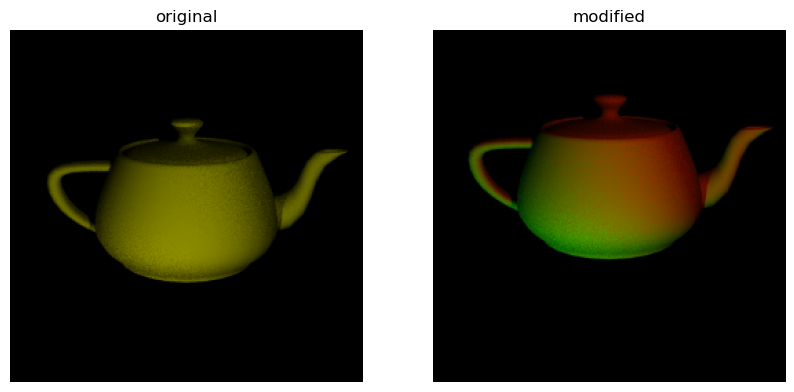

In [13]:
modified_image = mi.render(scene, spp=256)
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1,2,1).imshow(original_image); plt.axis('off'); plt.title('original')
fig.add_subplot(1,2,2).imshow(modified_image); plt.axis('off'); plt.title('modified');

# Rendering from multiple view points

- Load Mitsuba objects

- Create sensors

- Render a scene from a specified sensor

In [14]:
mi.set_variant("scalar_rgb")

Loading a scene from `dict`

In [15]:
# Create an alias for convenience
from mitsuba import ScalarTransform4f as T

scene = mi.load_dict({
    'type': 'scene',
    # The keys below correspond to object IDs and can be chosen arbitrarily
    'integrator': {'type': 'path'},
    'light': {'type': 'constant'},
    'teapot': {
        'type': 'ply',
        'filename': '../scenes/meshes/teapot.ply',#导入模型网格
        'to_world': T.translate([0, 0, -1.5]),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {'type': 'rgb', 'value': [0.1, 0.2, 0.3]},
        },
    },
})

Load Sensor

In [16]:
def load_sensor(r, phi, theta):
    # Apply two rotations to convert from spherical coordinates to world 3D coordinates.
    origin = T.rotate([0, 0, 1], phi).rotate([0, 1, 0], theta) @ mi.ScalarPoint3f([0, 0, r])

    return mi.load_dict({
        'type': 'perspective',
        'fov': 39.3077,
        'to_world': T.look_at(
            origin=origin,
            target=[0, 0, 0],
            up=[0, 0, 1]
        ),
        'sampler': {
            'type': 'independent',
            'sample_count': 16
        },
        'film': {
            'type': 'hdrfilm',
            'width': 256,
            'height': 256,
            'rfilter': {
                'type': 'tent',
            },
            'pixel_format': 'rgb',
        },
    })

多视角

In [17]:
sensor_count = 6

radius = 12
phis = [20.0 * i for i in range(sensor_count)]
theta = 60.0

sensors = [load_sensor(radius, phi, theta) for phi in phis]

render 的更多参数设置

In [18]:
images = [mi.render(scene, spp=16, sensor=sensor) for sensor in sensors]


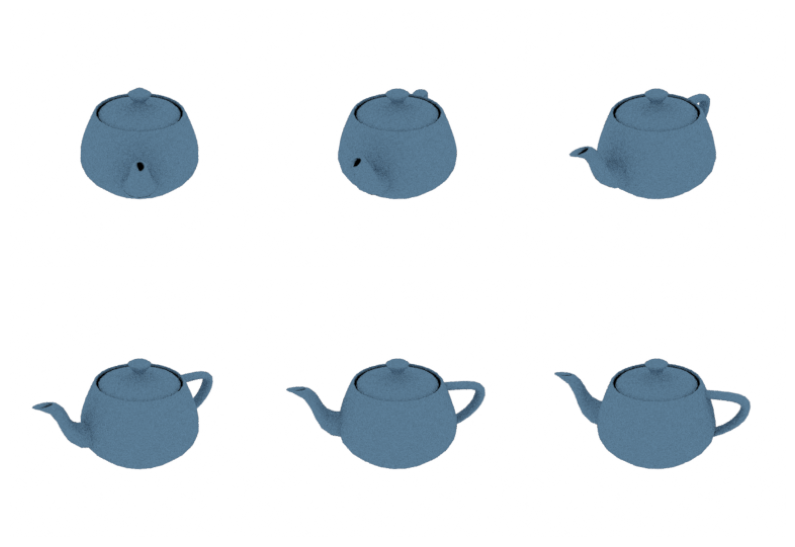

In [19]:
fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(sensor_count):
    ax = fig.add_subplot(2, 3, i + 1).imshow(images[i] ** (1.0 / 2.2))
    plt.axis("off")